In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For neural networks
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("TensorFlow not available. LSTM model will be skipped.")
    TENSORFLOW_AVAILABLE = False


In [ ]:
class CovidTimeSeriesForecaster:
    def __init__(self, data_path=None, sample_data=None):
        """
        Initialize the forecaster with either a file path or sample data
        """
        self.scaler = MinMaxScaler()
        self.models = {}
        self.predictions = {}
        self.metrics = {}

        if data_path:
            self.df = pd.read_csv(data_path)
        elif sample_data:
            from io import StringIO
            self.df = pd.read_csv(StringIO(sample_data))
        else:
            raise ValueError("Either data_path or sample_data must be provided")

        self.preprocess_data()

    def preprocess_data(self):
        """
        Preprocess the COVID-19 data
        """
        # Get date columns (exclude first 4 columns: Province/State, Country/Region, Lat, Long)
        date_columns = self.df.columns[4:]

        # Convert date columns to datetime
        self.dates = pd.to_datetime(date_columns, format='%m/%d/%y')

        # Create a mapping of countries
        self.countries = self.df['Country/Region'].unique()
        print(f"Available countries: {list(self.countries)[:10]}...")  # Show first 10

    def prepare_country_data(self, country):
        """
        Prepare time series data for a specific country
        """
        # Filter data for the specified country
        country_data = self.df[self.df['Country/Region'] == country]

        if len(country_data) == 0:
            raise ValueError(f"Country '{country}' not found in dataset")

        # If multiple rows for same country (different provinces), sum them
        if len(country_data) > 1:
            # Sum across all provinces/states for the country
            cases = country_data.iloc[:, 4:].sum().values
        else:
            cases = country_data.iloc[:, 4:].values[0]

        # Create DataFrame with dates and cases
        ts_data = pd.DataFrame({
            'date': self.dates,
            'cases': cases
        })

        # Calculate daily new cases
        ts_data['daily_cases'] = ts_data['cases'].diff().fillna(0)
        ts_data['daily_cases'] = ts_data['daily_cases'].clip(lower=0)  # Remove negative values

        return ts_data

    def create_sequences(self, data, sequence_length):
        """
        Create sequences for time series prediction
        """
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:(i + sequence_length)])
            y.append(data[i + sequence_length])
        return np.array(X), np.array(y)

    def train_linear_regression(self, X_train, y_train, X_test):
        """
        Train Linear Regression model
        """
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        self.models['Linear Regression'] = model
        return predictions

    def train_random_forest(self, X_train, y_train, X_test):
        """
        Train Random Forest model
        """
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        self.models['Random Forest'] = model
        return predictions

    def train_lstm(self, X_train, y_train, X_test, sequence_length):
        """
        Train LSTM model
        """
        if not TENSORFLOW_AVAILABLE:
            print("TensorFlow not available, skipping LSTM model")
            return np.zeros(len(X_test))

        # Reshape data for LSTM
        X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Build LSTM model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Train model
        history = model.fit(
            X_train_lstm, y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.1,
            verbose=0
        )

        # Make predictions
        predictions = model.predict(X_test_lstm)
        predictions = predictions.flatten()

        self.models['LSTM'] = model
        return predictions

    def calculate_metrics(self, y_true, y_pred, model_name):
        """
        Calculate evaluation metrics
        """
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        self.metrics[model_name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

        return mae, mse, rmse, r2

    def forecast_country(self, country, sequence_length=30, test_size=0.2, target='cases'):
        """
        Forecast COVID-19 cases for a specific country using multiple models
        """
        print(f"\n=== Forecasting for {country} ===")

        # Prepare data
        ts_data = self.prepare_country_data(country)

        # Use either total cases or daily cases
        if target == 'daily_cases':
            values = ts_data['daily_cases'].values
            print(f"Forecasting daily new cases")
        else:
            values = ts_data['cases'].values
            print(f"Forecasting cumulative cases")

        # Scale the data
        values_scaled = self.scaler.fit_transform(values.reshape(-1, 1)).flatten()

        # Create sequences
        X, y = self.create_sequences(values_scaled, sequence_length)

        # Split data
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

        # Train models and make predictions
        models_to_train = [
            ('Linear Regression', self.train_linear_regression),
            ('Random Forest', self.train_random_forest),
        ]

        if TENSORFLOW_AVAILABLE:
            models_to_train.append(('LSTM', lambda X_tr, y_tr, X_te: self.train_lstm(X_tr, y_tr, X_te, sequence_length)))

        for model_name, train_func in models_to_train:
            print(f"\nTraining {model_name}...")

            if model_name == 'LSTM':
                predictions_scaled = train_func(X_train, y_train, X_test)
            else:
                predictions_scaled = train_func(X_train, y_train, X_test)

            # Inverse transform predictions
            predictions = self.scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
            y_test_original = self.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

            # Store predictions
            self.predictions[model_name] = {
                'predictions': predictions,
                'actual': y_test_original,
                'dates': ts_data['date'].iloc[split_idx + sequence_length:].values
            }

            # Calculate metrics
            mae, mse, rmse, r2 = self.calculate_metrics(y_test_original, predictions, model_name)
            print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

        # Store original time series data for plotting
        self.original_data = ts_data
        self.target_column = target
        self.split_idx = split_idx
        self.sequence_length = sequence_length

        return self.predictions, self.metrics

    def plot_predictions(self, country, figsize=(20, 10)):
        """
        Plot original time series and predictions from different models
        """
        if not self.predictions:
            print("No predictions available. Run forecast_country first.")
            return

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'COVID-19 {self.target_column.replace("_", " ").title()} Prediction for {country}',
                     fontsize=16, fontweight='bold')

        # Plot 1: Full time series with train/test split
        ax1 = axes[0, 0]
        train_data = self.original_data[self.target_column].iloc[:self.split_idx + self.sequence_length]
        test_data = self.original_data[self.target_column].iloc[self.split_idx + self.sequence_length:]

        ax1.plot(self.original_data['date'].iloc[:self.split_idx + self.sequence_length],
                train_data, label='Training Data', color='blue', alpha=0.7)
        ax1.plot(self.original_data['date'].iloc[self.split_idx + self.sequence_length:],
                test_data, label='Actual Test Data', color='green', linewidth=2)

        ax1.axvline(x=self.original_data['date'].iloc[self.split_idx + self.sequence_length],
                   color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
        ax1.set_title('Full Time Series with Train/Test Split')
        ax1.set_ylabel('Cases')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Predictions comparison
        ax2 = axes[0, 1]
        colors = ['red', 'purple', 'orange', 'brown']

        # Plot actual test data
        actual_dates = list(self.predictions.values())[0]['dates']
        actual_values = list(self.predictions.values())[0]['actual']
        ax2.plot(actual_dates, actual_values, label='Actual', color='green', linewidth=2, marker='o', markersize=3)

        # Plot predictions from each model
        for i, (model_name, pred_data) in enumerate(self.predictions.items()):
            ax2.plot(pred_data['dates'], pred_data['predictions'],
                    label=f'{model_name}', color=colors[i % len(colors)],
                    linewidth=2, marker='s', markersize=2, alpha=0.8)

        ax2.set_title('Model Predictions vs Actual (Test Period)')
        ax2.set_ylabel('Cases')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Metrics comparison
        ax3 = axes[1, 0]
        metrics_df = pd.DataFrame(self.metrics).T
        metrics_to_plot = ['MAE', 'RMSE']
        x = np.arange(len(self.metrics))
        width = 0.35

        for i, metric in enumerate(metrics_to_plot):
            ax3.bar(x + i*width, metrics_df[metric], width, label=metric, alpha=0.7)

        ax3.set_title('Model Performance Metrics')
        ax3.set_ylabel('Error Value')
        ax3.set_xticks(x + width/2)
        ax3.set_xticklabels(list(self.metrics.keys()), rotation=45)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: R² scores
        ax4 = axes[1, 1]
        r2_scores = [self.metrics[model]['R²'] for model in self.metrics.keys()]
        colors_r2 = plt.cm.Set3(np.linspace(0, 1, len(r2_scores)))

        bars = ax4.bar(list(self.metrics.keys()), r2_scores, color=colors_r2, alpha=0.7)
        ax4.set_title('Model R² Scores')
        ax4.set_ylabel('R² Score')
        ax4.set_ylim(0, 1)
        ax4.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, score in zip(bars, r2_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print metrics summary
        print("\n=== Model Performance Summary ===")
        metrics_df = pd.DataFrame(self.metrics).T
        print(metrics_df.round(3))


In [ ]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2025-09-25 11:15:12--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819904 (1.7M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]   1.74M  --.-KB/s    in 0.06s   

2025-09-25 11:15:13 (30.0 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [1819904/1819904]



COVID-19 Time Series Forecasting
Available countries: ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia']...

=== Forecasting for Austria ===
Forecasting cumulative cases
Training samples: 793, Test samples: 340

Training Linear Regression...
Linear Regression - MAE: 3262.17, RMSE: 5376.81, R²: 1.000

Training Random Forest...
Random Forest - MAE: 1149238.37, RMSE: 1301668.98, R²: -3.535

Training LSTM...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
LSTM - MAE: 63314.46, RMSE: 66803.70, R²: 0.988


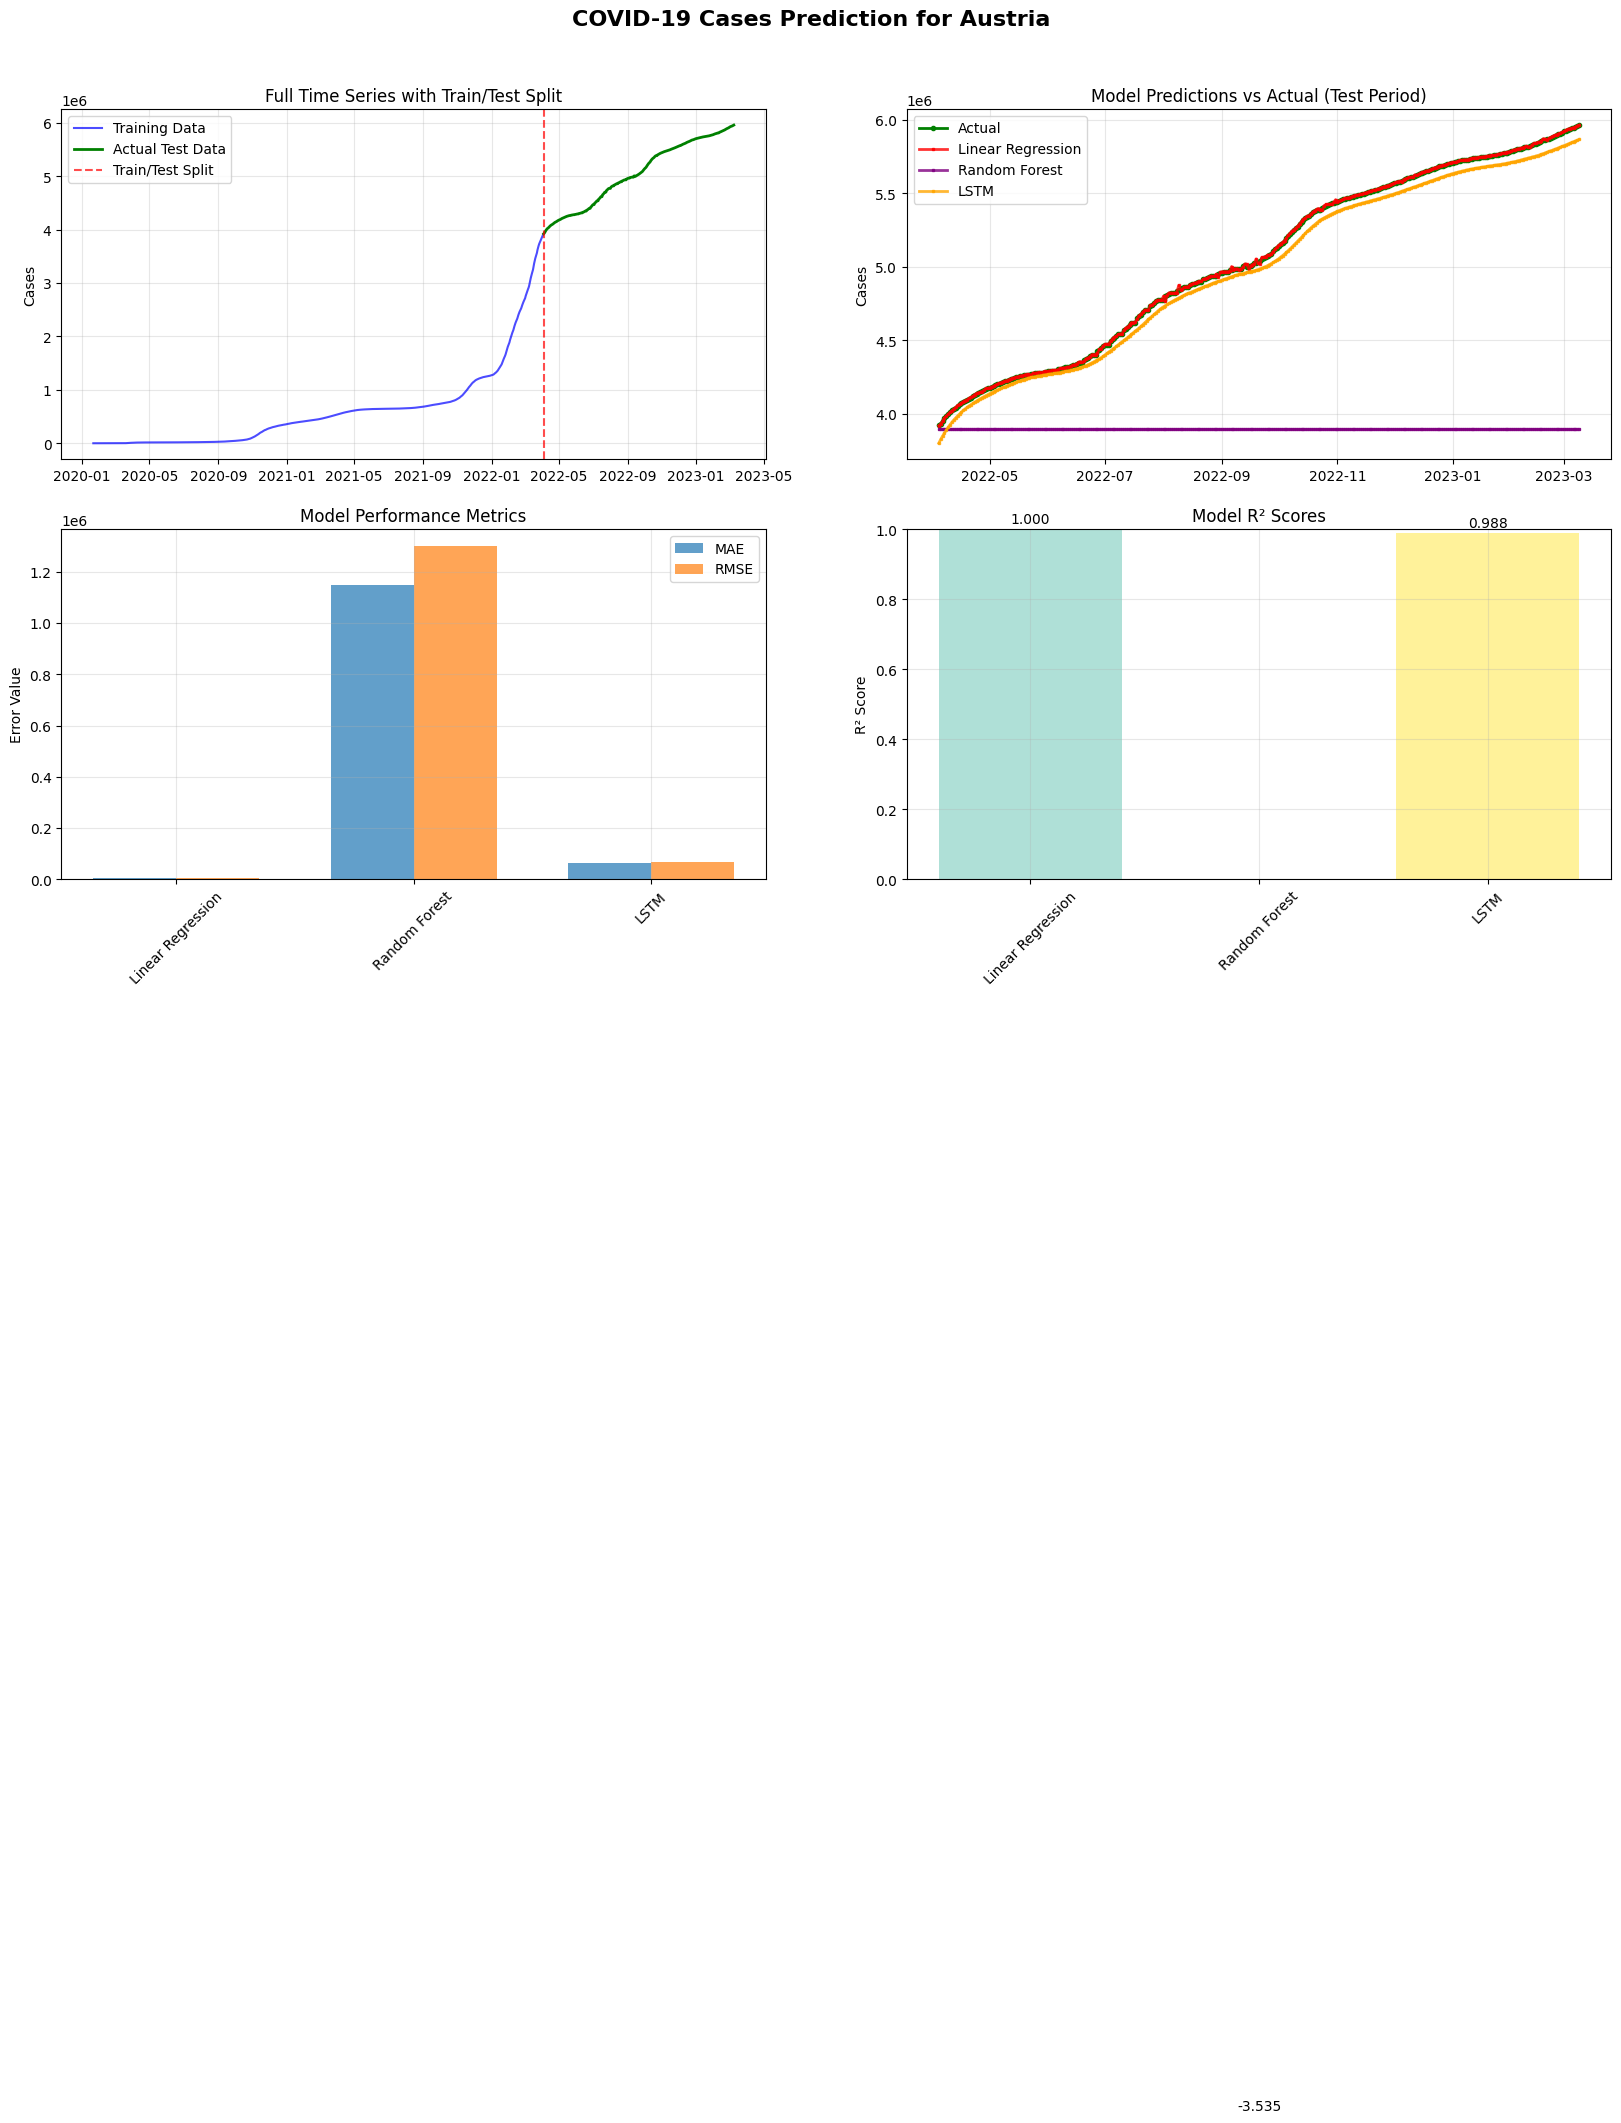


=== Model Performance Summary ===
                           MAE           MSE         RMSE     R²
Linear Regression     3262.170  2.891007e+07     5376.809  1.000
Random Forest      1149238.369  1.694342e+12  1301668.975 -3.535
LSTM                 63314.462  4.462734e+09    66803.696  0.988

=== Usage Instructions ===
1. Replace 'sample_data' with your actual CSV file path:
   forecaster = CovidTimeSeriesForecaster(data_path='path/to/your/covid_data.csv')
2. Try different countries:
   Available countries: ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola'] ...
3. Adjust parameters:
   - sequence_length: Number of previous days to use for prediction
   - test_size: Fraction of data to use for testing
   - target: 'cases' for cumulative or 'daily_cases' for daily new cases
4. Example with different parameters:
   forecaster.forecast_country('Algeria', sequence_length=30, test_size=0.2, target='daily_cases')


In [ ]:
# Create forecaster and run analysis
print("COVID-19 Time Series Forecasting")
print("=" * 40)

forecaster = CovidTimeSeriesForecaster(data_path='time_series_covid19_confirmed_global.csv')

# Example: Forecast for Argentina (has good growth pattern)
country = "Austria"
predictions, metrics = forecaster.forecast_country(country, sequence_length=10, test_size=0.3, target='cases')

# Plot results
forecaster.plot_predictions(country)

print("\n=== Usage Instructions ===")
print("1. Replace 'sample_data' with your actual CSV file path:")
print("   forecaster = CovidTimeSeriesForecaster(data_path='path/to/your/covid_data.csv')")
print("2. Try different countries:")
print("   Available countries:", list(forecaster.countries[:5]), "...")
print("3. Adjust parameters:")
print("   - sequence_length: Number of previous days to use for prediction")
print("   - test_size: Fraction of data to use for testing")
print("   - target: 'cases' for cumulative or 'daily_cases' for daily new cases")
print("4. Example with different parameters:")
print("   forecaster.forecast_country('Algeria', sequence_length=30, test_size=0.2, target='daily_cases')")